In [2]:
# uncomment for google colab

# !pip install ta
# !pip install pykalman
# !pip install pandas-datareader
# !pip install pandas
# !pip install matplotlib
# !pip install fast-ta
# !pip install yfinance
# !pip install mplfinance

# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib


# uncomment this part
# import talib

# !pip install ta
import ta 

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

# More Plotting libaries 
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# libraries for Data Download
import datetime
from pandas_datareader import data as pdr
import yfinance as yf

To use STOCH RSI instead of Money Flow Index: 

In [90]:
"""
Source for this STOCH RSI: (closest i could find to tradingview.com)
https://gist.github.com/ultragtx/6831eb04dfe9e6ff50d0f334bdcb847d
"""

def StochRSI(series, period=14, smoothK=3, smoothD=3):
    # Calculate RSI 
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI 
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.rolling(smoothK).mean()
    stochrsi_D = stochrsi_K.rolling(smoothD).mean()

    return stochrsi_K, stochrsi_D
  
def StochRSI_EMA(series, period=14, smoothK=3, smoothD=3):
    # Calculate RSI 
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI 
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.ewm(span=smoothK).mean()
    stochrsi_D = stochrsi_K.ewm(span=smoothD).mean()

    return stochrsi_K, stochrsi_D

In [221]:
def plot_chart(data, n,m,i, ticker): # add i here for the gif script
    
    # Filter number of observations to plot
    data = data.iloc[n:m,:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    # ax_VWAP = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    # ax_PS = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    # ax_CCI = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_MFI = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    # ax_candle.plot(data.index, data["EMA50"], label="EMA50",c = '#4d00ff')
    # ax_candle.plot(data.index, data["EMA100"], label="EMA100",c = '#9001f0')
    # ax_candle.plot(data.index, data["EMA200"], label="EMA200",c = '#d102e8')
    # ax_candle.plot(data.index, data["EMA300"], label="EMA300",c = '#f101c2')
    # ax_candle.plot(data.index, data['VWAP'], label='Volume Weighted Average Price', c='#4d00ff', alpha = 0.7)
    ax_candle.plot(data.index, data["MA200"], label="MA200",c = '#e80030', alpha = 0.3)
    ax_candle.plot(data.index, data["MA5"], label="MA5",c = '#ff5400', alpha = 0.3)
    ax_candle.plot(data.index, data["MA10"], label="MA10",c = '#9e0059', alpha = 0.3)
    ax_candle.plot(data.index, data["MA300"], label="MA300",c = '#f101c2', alpha = 0.3)
    ax_candle.plot(data.index, data["upperband"], label = 'Upper BB', c= '#22223b', alpha = 0.7)
    ax_candle.plot(data.index, data["middleband"], label = 'Middle BB', c= '#4a4e69',linestyle='--')
    ax_candle.plot(data.index, data["lowerband"], label = 'Lower BB', c= '#22223b', alpha = 0.7)
    ax_candle.fill_between(data.index, data["upperband"], data["lowerband"], color= '#22223b', alpha = 0.05)
    candlestick_ohlc(ax_candle, ohlc, colorup="#00f5d4", colordown="#ef233c", width=0.8)
    ax_candle.plot(data.index, data['Buy_Signal'], '^', markersize=10, color='#59cd90')
    ax_candle.plot(data.index, data['Sell_Signal'], 'v', markersize=10, color='#960018')
    ax_candle.set_ylabel(f"{tick} Daily Candle Stick")
    ax_candle.legend()
    
    # Plot MACD
    ax_macd.plot(data.index, data["macd"], label="MACD", c = '#22223b')
    ax_macd.plot(data.index, data["macd_EMA50"], label="MACD EMA 50", c = '#22223b', alpha = 0.7)
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist", color = '#22223b', alpha = 0.7)
    ax_macd.plot(data.index, data["macd_signal"], label="signal", c = '#ef233c')
    ax_macd.fill_between(data.index, data["macd"], data["macd_EMA50"], where=(data["macd"] > data["macd_EMA50"]), color= '#00f5d4', alpha = 0.05)
    ax_macd.fill_between(data.index, data["macd_signal"], data["macd_EMA50"], where=(data["macd_signal"] > data["macd_EMA50"]) ,color= '#00f5d4', alpha = 0.05)
    ax_macd.fill_between(data.index, data["macd"], data["macd_EMA50"], where=(data["macd"] < data["macd_EMA50"]), color= '#ef233c', alpha = 0.05)
    ax_macd.fill_between(data.index, data["macd_signal"], data["macd_EMA50"], where=(data["macd_signal"] < data["macd_EMA50"]) ,color= '#ef233c', alpha = 0.05)
    ax_macd.plot(data.index, data['macd_buy_signal'], '^', markersize=10, color='#59cd90')
    ax_macd.plot(data.index, data['macd_sell_signal'], 'v', markersize=10, color='#960018')
    ax_macd.set_ylabel("Moving Average Convergence Divergence")
    ax_macd.legend()

    # Pattern Score
    # ax_PS.plot(data.index, [100] * len(data.index),c = '#22223b')
    # ax_PS.plot(data.index, [0] * len(data.index), c = '#22223b',linestyle='--')
    # ax_PS.plot(data.index, [-100] * len(data.index),c = '#22223b')
    # ax_PS.plot(data.index, data['pattern_score'], label="Pattern Score", c='#22223b',alpha = 0.7)
    # ax_PS.plot(data.index, data['pattern_score'].ewm(span=10).mean(), label="Pattern Score EMA10", c='#ef233c',alpha = 0.7)
    # ax_PS.set_ylabel("Pattern Score") 
    # ax_PS.legend()

    # Plot CCI
    # ax_CCI.plot(data.index, [100] * len(data.index),c = '#22223b')
    # ax_CCI.plot(data.index, [0] * len(data.index), c = '#22223b',linestyle='--')
    # ax_CCI.plot(data.index, [-100] * len(data.index),c = '#22223b')
    # ax_CCI.fill_between(data.index, data["CCI"], [-100]*len(data.index), where=(data["CCI"] < [-100]*len(data.index)), color= '#ef233c', alpha = 0.1)
    # ax_CCI.fill_between(data.index, data["CCI"], [100]*len(data.index), where=(data["CCI"] > [100]*len(data.index)), color= '#00f5d4', alpha = 0.1)
    # ax_CCI.plot(data.index, data["CCI"], label="Commodity Channel Index", c='#ef233c',alpha = 0.7)
    # # ax_CCI.plot(data.index, data['Volume_pct']*100000,label="Volume Scaled Rate of Change", c = '#22223b', alpha = 0.1  )
    # ax_CCI.plot(data.index, data['CCI_buy_signal'], '^', markersize=10, color='#59cd90')
    # ax_CCI.plot(data.index, data['CCI_sell_signal'], 'v', markersize=10, color='#960018')
    # ax_CCI.set_ylabel("Commodity Channel Index") 
    # ax_CCI.legend()

    # Volume on same axis
    ax_vol.bar(data.index, data["Volume"] / 1000000, color = '#22223b', alpha = 0.25)
    ax_vol.set_ylabel("Volume Millions")
    ax_vol.grid(False)

    # STOCH RSI
    ax_RSI=ax_vol.twinx()
    ax_RSI.plot(data.index, data['stochrsi_K']*100, label="RSI K%", c = '#22223b', alpha = 0.7)
    ax_RSI.plot(data.index, data['stochrsi_D']*100, label="RSI D%", c = '#ef233c', alpha = 0.7)
    ax_RSI.plot(data.index, data['stochrsi_K_EMA50']*100, label="RSI EMA50", c = '#22223b', alpha = 0.5)
    ax_RSI.fill_between(data.index, data['stochrsi_K_EMA50']*100, data['stochrsi_K']*100, where=(data['stochrsi_K']*100 > data['stochrsi_K_EMA50']*100), color= '#00f5d4', alpha = 0.05)
    ax_RSI.fill_between(data.index, data['stochrsi_K_EMA50']*100, data['stochrsi_K']*100, where=(data['stochrsi_K']*100 < data['stochrsi_K_EMA50']*100), color= '#ef233c', alpha = 0.05)
    ax_RSI.plot(data.index, [80] * len(data.index),c = '#22223b')
    ax_RSI.plot(data.index, [20] * len(data.index),c = '#22223b')
    ax_RSI.plot(data.index, data['RSI_buy_signal'], '^', markersize=10, color='#59cd90')
    ax_RSI.plot(data.index, data['RSI_sell_signal'], 'v', markersize=10, color='#960018')
    ax_RSI.set_ylabel("Stochastic RSI") 
    ax_RSI.legend()
    
    # Money Flow Index
    # ax_MFI=ax_vol.twinx()
    ax_MFI.plot(data.index, [20] * len(data.index),c = '#22223b')
    ax_MFI.plot(data.index, data['Mean_Center_MFI'], c = '#22223b', label = "Mean Center MFI",alpha = 0.7) # Change these to stoch 
    ax_MFI.plot(data.index, [0] * len(data.index), c = '#22223b',linestyle='--')
    ax_MFI.plot(data.index, data['EMA50_Mean_Center_MFI'], c = '#ef233c', label = "MFI EMA50",alpha = 0.7)
    ax_MFI.plot(data.index, [-20] * len(data.index),c = '#22223b')
    ax_MFI.plot(data.index, data['MFI_buy_signal'], '^', markersize=10, color='#59cd90')
    ax_MFI.plot(data.index, data['MFI_sell_signal'], 'v', markersize=10, color='#960018')
    ax_MFI.set_ylabel("Money Flow Index")
    ax_MFI.legend()

    # # VWAP & EMAs
    # ax_VWAP=ax_vol.twinx() # change this based on which you want to show with it
    # ax_VWAP.plot(data.index, data['VWAP'], label='Volume Weighted Average Price', c='#22223b', alpha = 1)
    # ax_VWAP.plot(data.index, data['EMA9'], label='EMA9', c='#ef233c',alpha = 0.333 )
    # ax_VWAP.plot(data.index, data['EMA50'], label='EMA50', c='#ef233c', alpha = 0.666)
    # ax_VWAP.plot(data.index, data["MA200"], label="MA200",c = '#ef233c', alpha = 1)
    # ax_VWAP.fill_between(data.index, data['EMA9'], data['EMA50'], where=(data['EMA9'] > data['EMA50']), color= '#00f5d4', alpha = 0.02)
    # ax_VWAP.fill_between(data.index, data['EMA9'], data['MA200'], where=(data['EMA9'] > data['MA200']), color= '#00f5d4', alpha = 0.02)
    # ax_VWAP.fill_between(data.index, data['MA200'], data['EMA50'], where=(data['EMA50'] > data['MA200']), color= '#00f5d4', alpha = 0.02)
    # ax_VWAP.fill_between(data.index, data['EMA9'], data['EMA50'], where=(data['EMA9'] < data['EMA50']), color= '#ef233c', alpha = 0.02)
    # ax_VWAP.fill_between(data.index, data['EMA9'], data['MA200'], where=(data['EMA9'] < data['MA200']), color= '#ef233c', alpha = 0.02)
    # ax_VWAP.fill_between(data.index, data['MA200'], data['EMA50'], where=(data['EMA50'] < data['MA200']), color= '#ef233c', alpha = 0.02)
    # ax_VWAP.plot(data.index, data['VWAP_buy_signal'], '^', markersize=10, color='#59cd90')
    # ax_VWAP.plot(data.index, data['VWAP_sell_signal'], 'v', markersize=10, color='#960018')
    # ax_VWAP.set_ylabel("Volume Weighted Average Price")
    # ax_VWAP.legend()

    # To save save the chart as PNG  
    fig.savefig(str(ticker) + str(i) + ".png", bbox_inches="tight")
    from google.colab import files
    files.download( str(ticker) + str(i) + ".png" )  
    
    plt.show()

In [133]:
def get_indicators(data):
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['Close'])
    # ema10 works well for crypto
    # data['macd_signal'] = data['macd_signal'].ewm(span=10).mean()
    data['macd_EMA50'] = data['macd'].ewm(span=50).mean()
    # data['macd_hist'] = data['macd_hist'].ewm(span=10).mean()
    data['macd_signal_s1'] = data['macd_signal'].shift(1)
    data['macd_s1'] = data['macd'].shift(1)
    data['macd_hist_s1'] = data['macd_hist'].shift(1)
    data['macd_hist_s2'] = data['macd_hist'].shift(2)
    data['macd_hist_s3'] = data['macd_hist'].shift(3)
    
    # Get EMAs and MAs
    data['EMA9'] = data['Close'].ewm(span=9).mean()
    data['EMA9_s1'] = data['EMA9'].shift(1)
    data['EMA5'] = data['Close'].ewm(span=5).mean()
    data['EMA10'] = data['Close'].ewm(span=10).mean()
    data['EMA50'] = data['Close'].ewm(span=50).mean()
    data['EMA50_s1'] = data['EMA50'].shift(1)
    data['EMA200'] = data['Close'].ewm(span=200).mean()
    data['EMA300'] = data['Close'].ewm(span=300).mean()

    data['MA200'] = data['Close'].rolling(window=200).mean()
    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA5_s1'] = data['MA5'].shift(1)
    data['MA10'] = data['Close'].rolling(window=10).mean()
    data['MA300'] = data['Close'].rolling(window=300).mean()
    data['MA10_s1'] = data['MA10'].shift(1)

    data['MA50'] = data['Close'].rolling(window=50).mean()

    # CCI 
    data["CCI"] = talib.CCI(data['High'], data['Low'], data['Close'], timeperiod=20)
    data["CCI_s1"] = data["CCI"].shift(1)
    
    # # Money flow index 14
    data['Money_flow_index14'] = ta.volume.money_flow_index(data['High'], data['Low'], data['Close'],
                                                          data['Volume'], n=14 , fillna =False)
    # Mean centered money flow index
    data['Mean_Center_MFI'] = data['Money_flow_index14'] - data['Money_flow_index14'].rolling(200, min_periods=20).mean()
    data['EMA50_Mean_Center_MFI'] = data['Mean_Center_MFI'].ewm(span=50).mean()

    # BB
    data["upperband"], data["middleband"], data["lowerband"] = talib.BBANDS(data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    ## FULL STO
    data['stochrsi_K'], data['stochrsi_D'] = StochRSI_EMA(data['Close'], period=14, smoothK=3, smoothD=3)
    data['stochrsi_K_s1'] = data['stochrsi_K'].shift(1)
    data['stochrsi_D_s1'] = data['stochrsi_D'].shift(1)
    data['stochrsi_K_EMA50'] = data['stochrsi_K'].ewm(span=50).mean()
    data['stochrsi_K_EMA50_s1'] = data['stochrsi_K_EMA50'].shift(1)

    # Volume
    data['Volume_s1'] = data['Volume'].shift(1)
    data['Volume_pct'] = data['Volume'].apply(np.log).pct_change().ewm(span=50).mean() # percentage change
    data['Volume_pct_s1'] = data['Volume_pct'].shift(1) 

    # Volume weighted average price
    data['VWAP'] = np.cumsum(data['Volume']*(data['High']+data['Low'])/2) / np.cumsum(data['Volume'])
    data['VWAP_s1'] = data['VWAP'].shift(1)

    # Previous Candle
    data['High_s1'] = data['High'].shift(1)
    data['Low_s1'] = data['Low'].shift(1)
    data['Open_s1'] = data['Open'].shift(1)
    data['Close_s1'] = data['Close'].shift(1)

    data['High_s2'] = data['High'].shift(2)
    data['Low_s2'] = data['Low'].shift(2)
    data['Open_s2'] = data['Open'].shift(2)
    data['Close_s2'] = data['Close'].shift(2)

    return data

In [114]:
def patterns(data):
  high = data['High']
  low = data['Low']
  open = data['Open']
  close= data['Close']

  data['1'] = talib.CDL2CROWS(open, high, low, close)
  data['2'] = talib.CDL3BLACKCROWS(open, high, low, close)
  data['3'] = talib.CDL3INSIDE(open, high, low, close)
  data['4'] = talib.CDL3LINESTRIKE(open, high, low, close)
  data['5'] = talib.CDL3OUTSIDE(open, high, low, close)
  data['6'] = talib.CDL3STARSINSOUTH(open, high, low, close)
  data['7'] = talib.CDL3WHITESOLDIERS(open, high, low, close)
  data['8'] = talib.CDLABANDONEDBABY(open, high, low, close, penetration=0)
  data['9'] = talib.CDLADVANCEBLOCK(open, high, low, close)
  data['10'] = talib.CDLBELTHOLD(open, high, low, close)
  data['11'] = talib.CDLBREAKAWAY(open, high, low, close)
  data['12'] = talib.CDLCLOSINGMARUBOZU(open, high, low, close)
  data['13'] = talib.CDLCONCEALBABYSWALL(open, high, low, close)
  data['14'] = talib.CDLCOUNTERATTACK(open, high, low, close)
  data['15'] = talib.CDLDARKCLOUDCOVER(open, high, low, close, penetration=0)
  data['16'] = talib.CDLDOJI(open, high, low, close)
  data['17'] = talib.CDLDOJISTAR(open, high, low, close)
  data['18'] = talib.CDLDRAGONFLYDOJI(open, high, low, close)
  data['19'] = talib.CDLENGULFING(open, high, low, close)
  data['20'] = talib.CDLEVENINGDOJISTAR(open, high, low, close, penetration=0)
  data['21'] = talib.CDLEVENINGSTAR(open, high, low, close, penetration=0)
  data['22'] = talib.CDLGAPSIDESIDEWHITE(open, high, low, close)
  data['23'] = talib.CDLGRAVESTONEDOJI(open, high, low, close)
  data['24'] = talib.CDLHAMMER(open, high, low, close)
  data['25'] = talib.CDLHANGINGMAN(open, high, low, close)
  data['26'] = talib.CDLHARAMI(open, high, low, close)
  data['27'] = talib.CDLHARAMICROSS(open, high, low, close)
  data['28'] = talib.CDLHIGHWAVE(open, high, low, close)
  data['29'] = talib.CDLHIKKAKE(open, high, low, close)
  data['30'] = talib.CDLHIKKAKEMOD(open, high, low, close)
  data['31'] = talib.CDLHOMINGPIGEON(open, high, low, close)
  data['32'] = talib.CDLIDENTICAL3CROWS(open, high, low, close)
  data['33'] = talib.CDLINNECK(open, high, low, close)
  data['34'] = talib.CDLINVERTEDHAMMER(open, high, low, close)
  data['35'] = talib.CDLKICKING(open, high, low, close)
  data['36'] = talib.CDLKICKINGBYLENGTH(open, high, low, close)
  data['37'] = talib.CDLLADDERBOTTOM(open, high, low, close)
  data['38'] = talib.CDLLONGLEGGEDDOJI(open, high, low, close)
  data['39'] = talib.CDLLONGLINE(open, high, low, close)
  data['40'] = talib.CDLMARUBOZU(open, high, low, close)
  data['41'] = talib.CDLMATCHINGLOW(open, high, low, close)
  data['42'] = talib.CDLMATHOLD(open, high, low, close, penetration=0)
  data['43'] = talib.CDLMORNINGDOJISTAR(open, high, low, close, penetration=0)
  data['44'] = talib.CDLMORNINGSTAR(open, high, low, close, penetration=0)
  data['45'] = talib.CDLONNECK(open, high, low, close)
  data['46'] = talib.CDLPIERCING(open, high, low, close)
  data['47'] = talib.CDLRICKSHAWMAN(open, high, low, close)
  data['48'] = talib.CDLRISEFALL3METHODS(open, high, low, close)
  data['49'] = talib.CDLSEPARATINGLINES(open, high, low, close)
  data['50'] = talib.CDLSHOOTINGSTAR(open, high, low, close)
  data['51'] = talib.CDLSHORTLINE(open, high, low, close)
  data['52'] = talib.CDLSPINNINGTOP(open, high, low, close)
  data['53'] = talib.CDLSTALLEDPATTERN(open, high, low, close)
  data['54'] = talib.CDLSTICKSANDWICH(open, high, low, close)
  data['55'] = talib.CDLTAKURI(open, high, low, close)
  data['56'] = talib.CDLTASUKIGAP(open, high, low, close)
  data['57'] = talib.CDLTHRUSTING(open, high, low, close)
  data['58'] = talib.CDLTRISTAR(open, high, low, close)
  data['59'] = talib.CDLUNIQUE3RIVER(open, high, low, close)
  data['60'] = talib.CDLUPSIDEGAP2CROWS(open, high, low, close)
  data['61'] = talib.CDLXSIDEGAP3METHODS(open, high, low, close)
  data['pattern_score'] = data.loc[:, '1':'61'].sum(axis=1)

  return data

Alter buy and sell conditions to try different strategies

In [226]:

def buy_conditions(s):

    # Pattern Score
    # if (s['19'] >= 100) and (s['Close'] < s['MA300']):
    #   return s['Close']
    # if (s['24'] >= 100) and (s['Close'] < s['MA300']):
    #   return s['Close']
    # if (s['48'] >= 100):
    #   return s['Close']
    # if (s['46'] >= 100) and (s['Close'] < s['MA300']):
    #   return s['Close']

    # MACD
    if (s['macd_signal_s1'] > s['macd_s1']) and (s['macd'] > s['macd_signal']): 
      return s['Close']
    if (s['macd_hist'] < 0) and (s['macd_hist_s3'] < s['macd_hist_s2'] < s['macd_hist_s1'] <s['macd_hist']) and (s['Close'] < s['MA200']): 
      return s['Close']

    # if (s['macd_hist'] < 0) and (s['macd_hist_s3'] < s['macd_hist_s2'] < s['macd_hist_s1'] <s['macd_hist']) and \
    # (s['Close'] > s['MA200']) and (s['Open'] < s['MA5']): 
    #   return s['Close']
    
    # # STOCH RSI
    # if (s['stochrsi_K_EMA50_s1'] > s['stochrsi_K_s1']) and (s['stochrsi_K_EMA50'] < s['stochrsi_K']) and (s['stochrsi_K_EMA50'] < 0.3): 
    #         return s['Close']

    # # EMA
    # if (s['EMA9_s1'] < s['EMA50_s1']) and (s['EMA9'] > s['EMA50']) and (s['Close'] < s['MA200']): 
    #   return s['Close']

    # # CCI
    # if (s['Close'] < s['MA200']):
    #   if (s['CCI_s1'] < 0) and (s['CCI'] > 0): 
    #     return s['Close']
    
    # if (s['CCI'] < -250) and (s['Close'] < s['MA200']): 
    #     return s['Close']
    else:
        return None # Do Nothing


def sell_conditions(s):

    # Pattern Score
    # if (s['26'] <= -100) and (s['Close'] > s['MA300']):
    #   return s['Close']
    # if (s['15'] <= -100) and (s['Close'] > s['MA300']):
    #   return s['Close']
    # if (s['21'] <= -100) and (s['Close'] > s['MA200']):
    #   return s['Close']
    # if (s['25'] <= -100) and (s['Close'] > s['MA300']):
    #   return s['Close']


    # if (s['MA5_s1'] > s['MA10_s1']) and (s['MA5'] < s['MA10']) and (s['MA200'] < s['Close'] ): 
    #   return s['Close']

    # MACD
    if (s['macd_signal_s1'] < s['macd_s1']) and (s['macd'] < s['macd_signal']) and (s['Close'] > s['MA200']): 
          return s['Close']
    if (s['macd_hist'] > 0) and (s['macd_hist_s3'] > s['macd_hist_s2'] > s['macd_hist_s1'] > s['macd_hist']) and (s['Close'] > s['MA200']): 
      return s['Close']

    if (s['macd_hist'] > 0) and (s['macd_hist_s3'] > s['macd_hist_s2'] > s['macd_hist_s1'] > s['macd_hist']) and \
    (s['Close'] < s['MA200']) and (s['middleband'] > s['Close']): 
      return s['Close']

    # # STOCH RSI
    # if (s['stochrsi_K_EMA50_s1'] < s['stochrsi_K_s1']) and (s['stochrsi_K_EMA50'] > s['stochrsi_K'])  and (s['stochrsi_K_EMA50'] > 0.7): 
    #         return s['Close']

    # # EMA
    # if (s['Open'] > s['upperband']) and (s['Close'] > s['upperband']) and (s['Close'] > s['EMA50'] ):
    #   return s['Close']
    # if (s['EMA9_s1'] > s['EMA50_s1']) and (s['EMA9'] < s['EMA50']) and (s['Close'] > s['MA200']): 
    #   return s['Close']

    # # CCI
    # if (s['CCI_s1'] > 0) and (s['CCI'] < 0) and (s['macd_signal'] > s['macd']) and (s['Close'] > s['MA200']): 
    #     return s['Close']

    # if (s['CCI'] > 200) and (s['Close'] > s['MA200']): 
    #     return s['Close']

    else:
        return None # Do Nothing


def macd_buy_signal(s):
    if (s['macd_signal_s1'] > s['macd_s1']) and (s['macd'] > s['macd_signal']): 
      return s['macd']
    # if (s['macd_hist'] < 0) and (s['macd_hist_s3'] < s['macd_hist_s2'] < s['macd_hist_s1'] <s['macd_hist']) and \
    # (s['Close'] < s['MA200']):  # add dont buy if greater than upppband
    #   return s['macd']
    else:
        return None # Do Nothing

def macd_sell_signal(s):
    if (s['macd_signal_s1'] < s['macd_s1']) and (s['macd'] < s['macd_signal']): 
      return s['macd']
    # if (s['macd_hist'] > 0) and (s['macd_hist_s3'] > s['macd_hist_s2'] > s['macd_hist_s1'] > s['macd_hist']) and \
    #  (s['EMA5'] > s['EMA10']): 
    #   return s['macd']
    else:
        return None # Do Nothing

# def cci_buy_signal(s):
#     if (s['CCI_s1'] < 0) and (s['CCI'] > 0): 
#       return s['CCI']
#     else:
#         return None # Do Nothing

# def cci_sell_signal(s):
#     if (s['CCI_s1'] > 0) and (s['CCI'] < 0): 
#       return s['CCI']
#     else:
#         return None # Do Nothing

def rsi_buy_signal(s):
    if (s['stochrsi_K_EMA50_s1'] > s['stochrsi_K_s1']) and (s['stochrsi_K_EMA50'] < s['stochrsi_K']): 
      return s['stochrsi_K_EMA50']*100
    else:
        return None # Do Nothing

def rsi_sell_signal(s):
    if (s['stochrsi_K_EMA50_s1'] < s['stochrsi_K_s1']) and (s['stochrsi_K_EMA50'] > s['stochrsi_K']): 
      return s['stochrsi_K_EMA50']*100
    else:
        return None # Do Nothing

# def vwap_buy_signal(s):
#     # if (s['EMA9_s1'] < s['VWAP_s1']) and (s['EMA9'] > s['VWAP']): 
#     #   return s['EMA9']
#     if (s['EMA9_s1'] < s['EMA50_s1']) and (s['EMA9'] > s['EMA50']) and (s['Close'] < s['MA200']): 
#       return s['EMA9']

#     else:
#         return None # Do Nothing

# def vwap_sell_signal(s):
#     # if (s['EMA9_s1'] > s['VWAP_s1']) and (s['EMA9'] < s['VWAP']): 
#     #   return s['EMA9']
#     if (s['EMA9_s1'] > s['EMA50_s1']) and (s['EMA9'] < s['EMA50']) and (s['Close'] > s['MA200']): 
#       return s['EMA9']
#     else:
#         return None # Do Nothing

# CHANGE TO MFI AND BUY AND SELL AT EMA50 TOUCHING -20 20
# turn this into when ema50 crosses the mfi above -+19
def MFI_buy_signal(s):
    if (s['EMA50_Mean_Center_MFI'] < -20) : 
      return s['EMA50_Mean_Center_MFI']
    else:
        return None # Do Nothing

def MFI_sell_signal(s):
    if (s['EMA50_Mean_Center_MFI'] > 20): 
      return s['EMA50_Mean_Center_MFI']
    else:
        return None # Do Nothing

[*********************100%***********************]  1 of 1 completed
********************* BTC-USD *********************


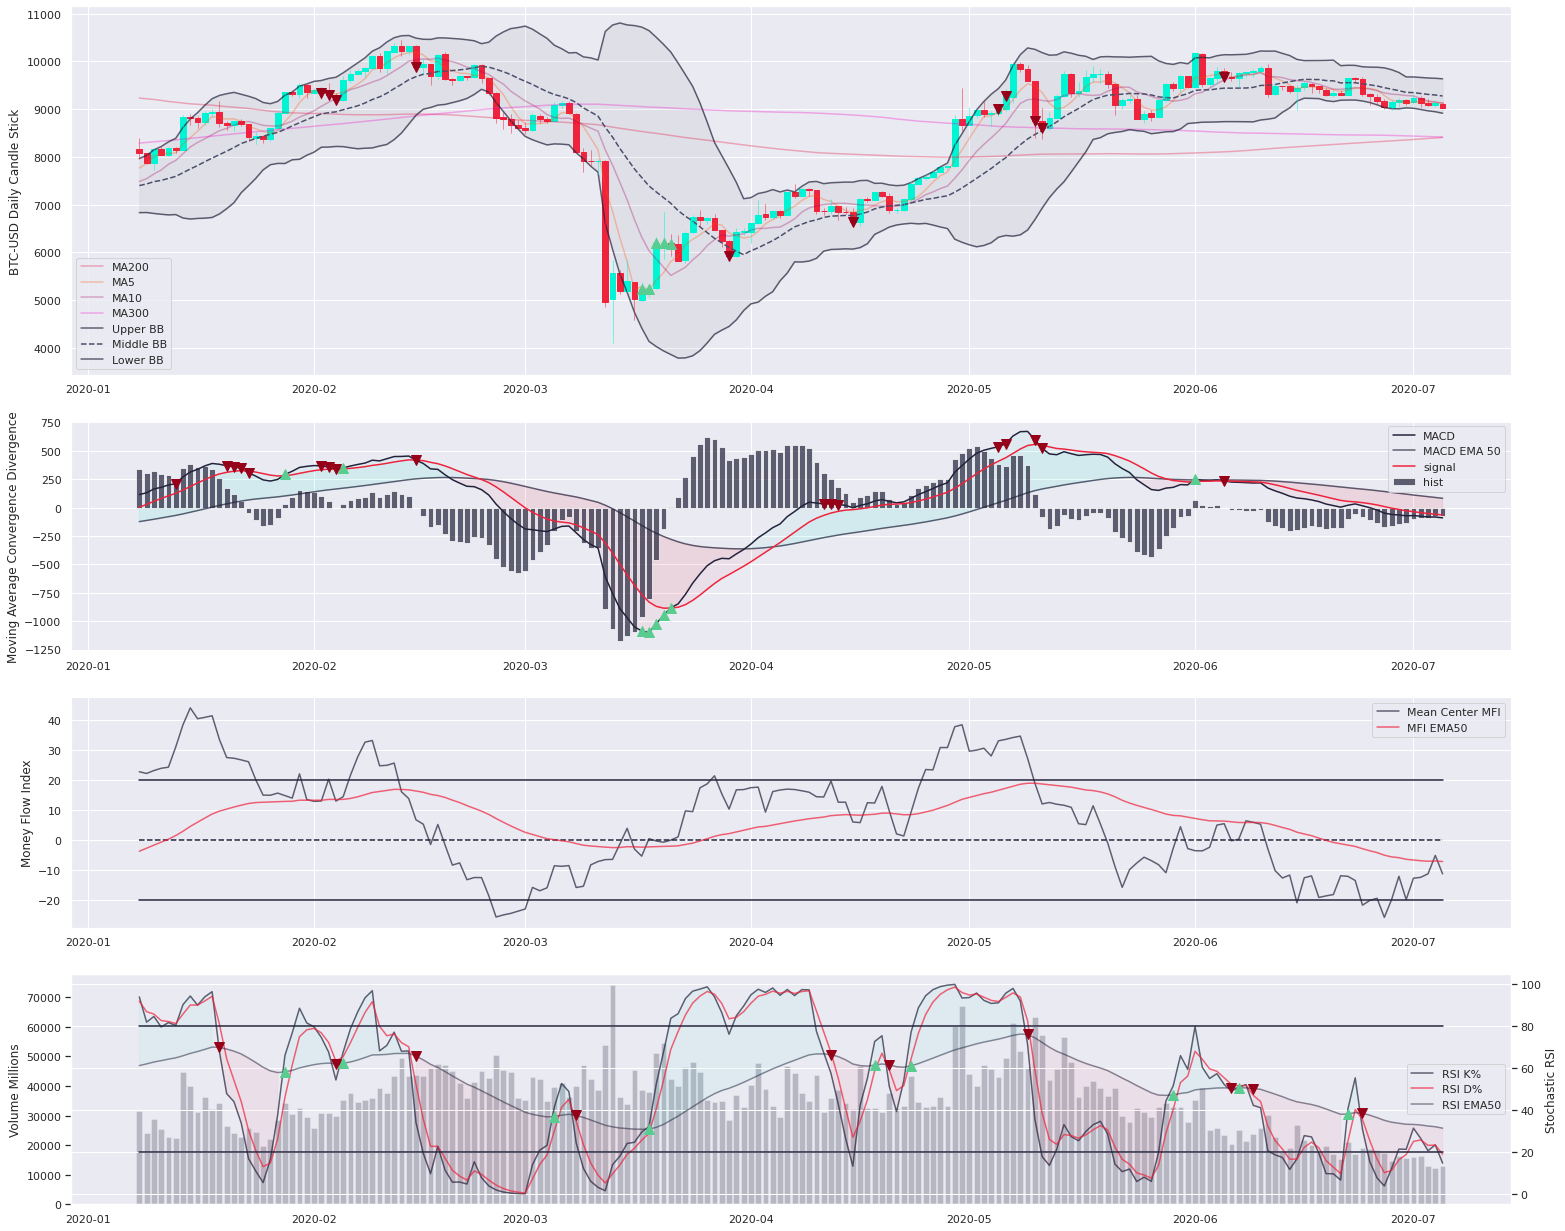

[*********************100%***********************]  1 of 1 completed
********************* ETH-USD *********************


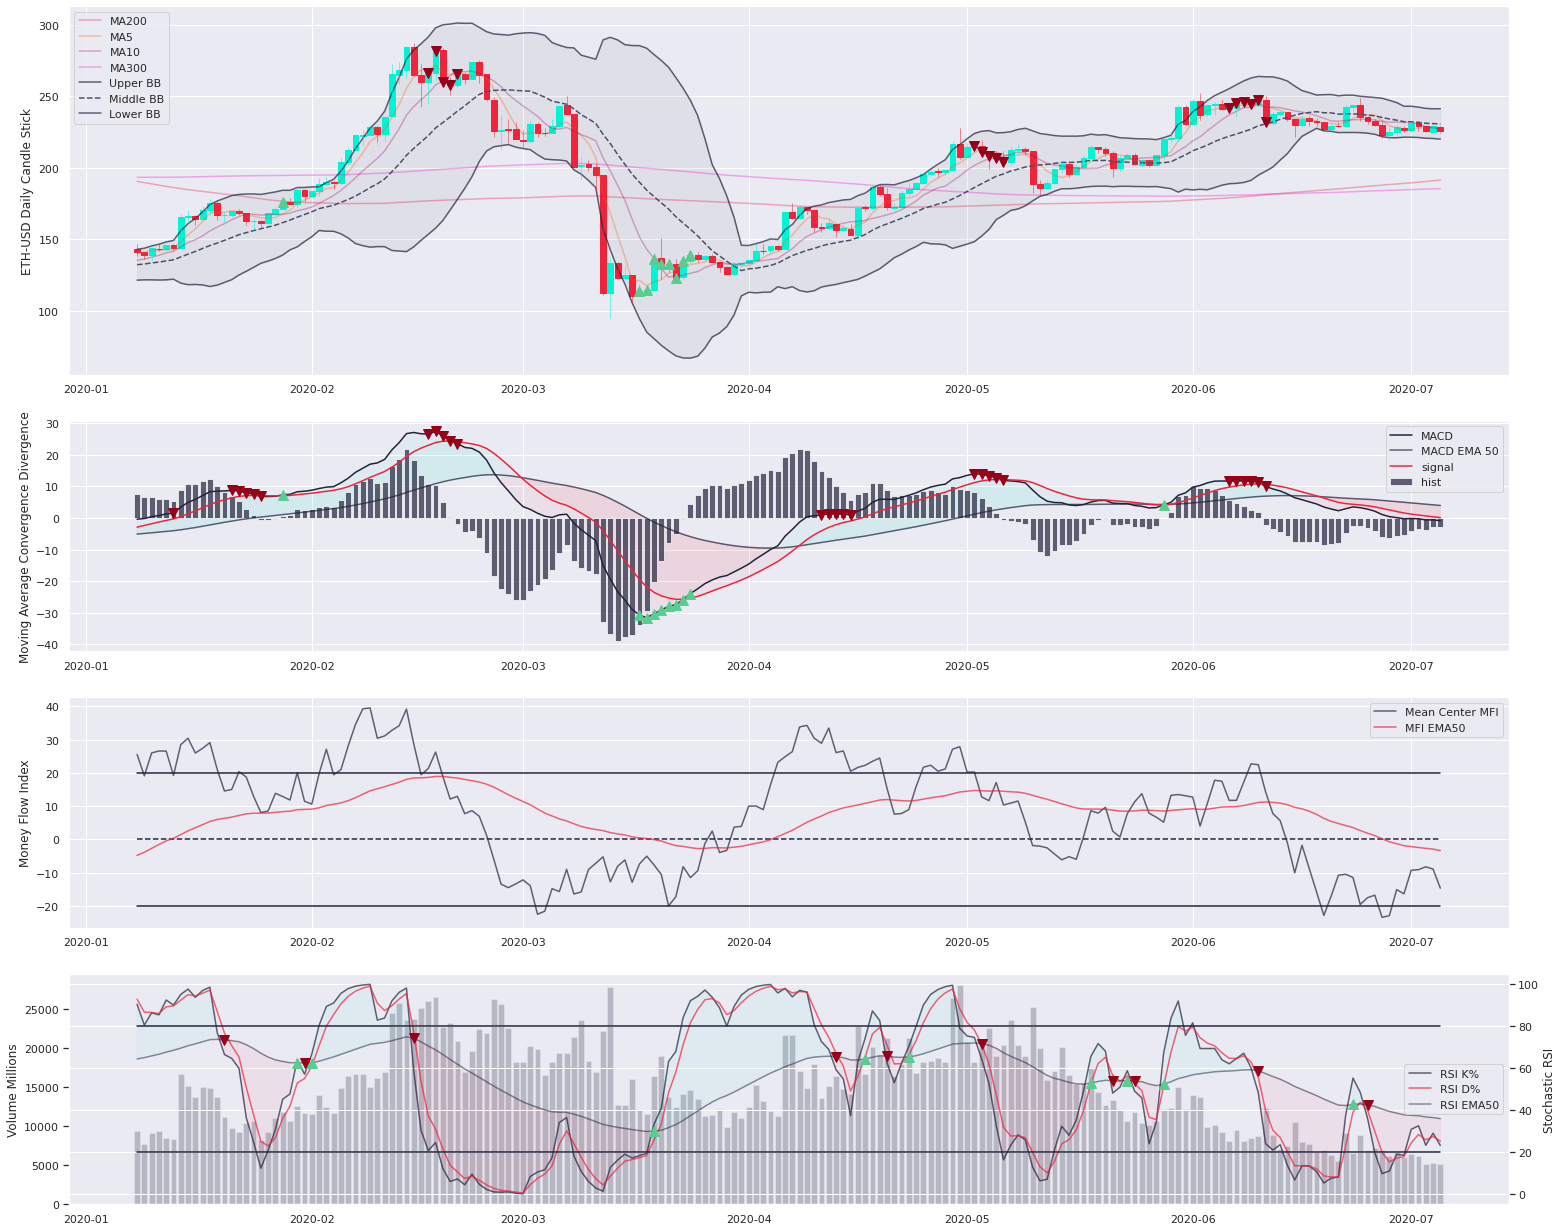

[*********************100%***********************]  1 of 1 completed
********************* LTC-USD *********************


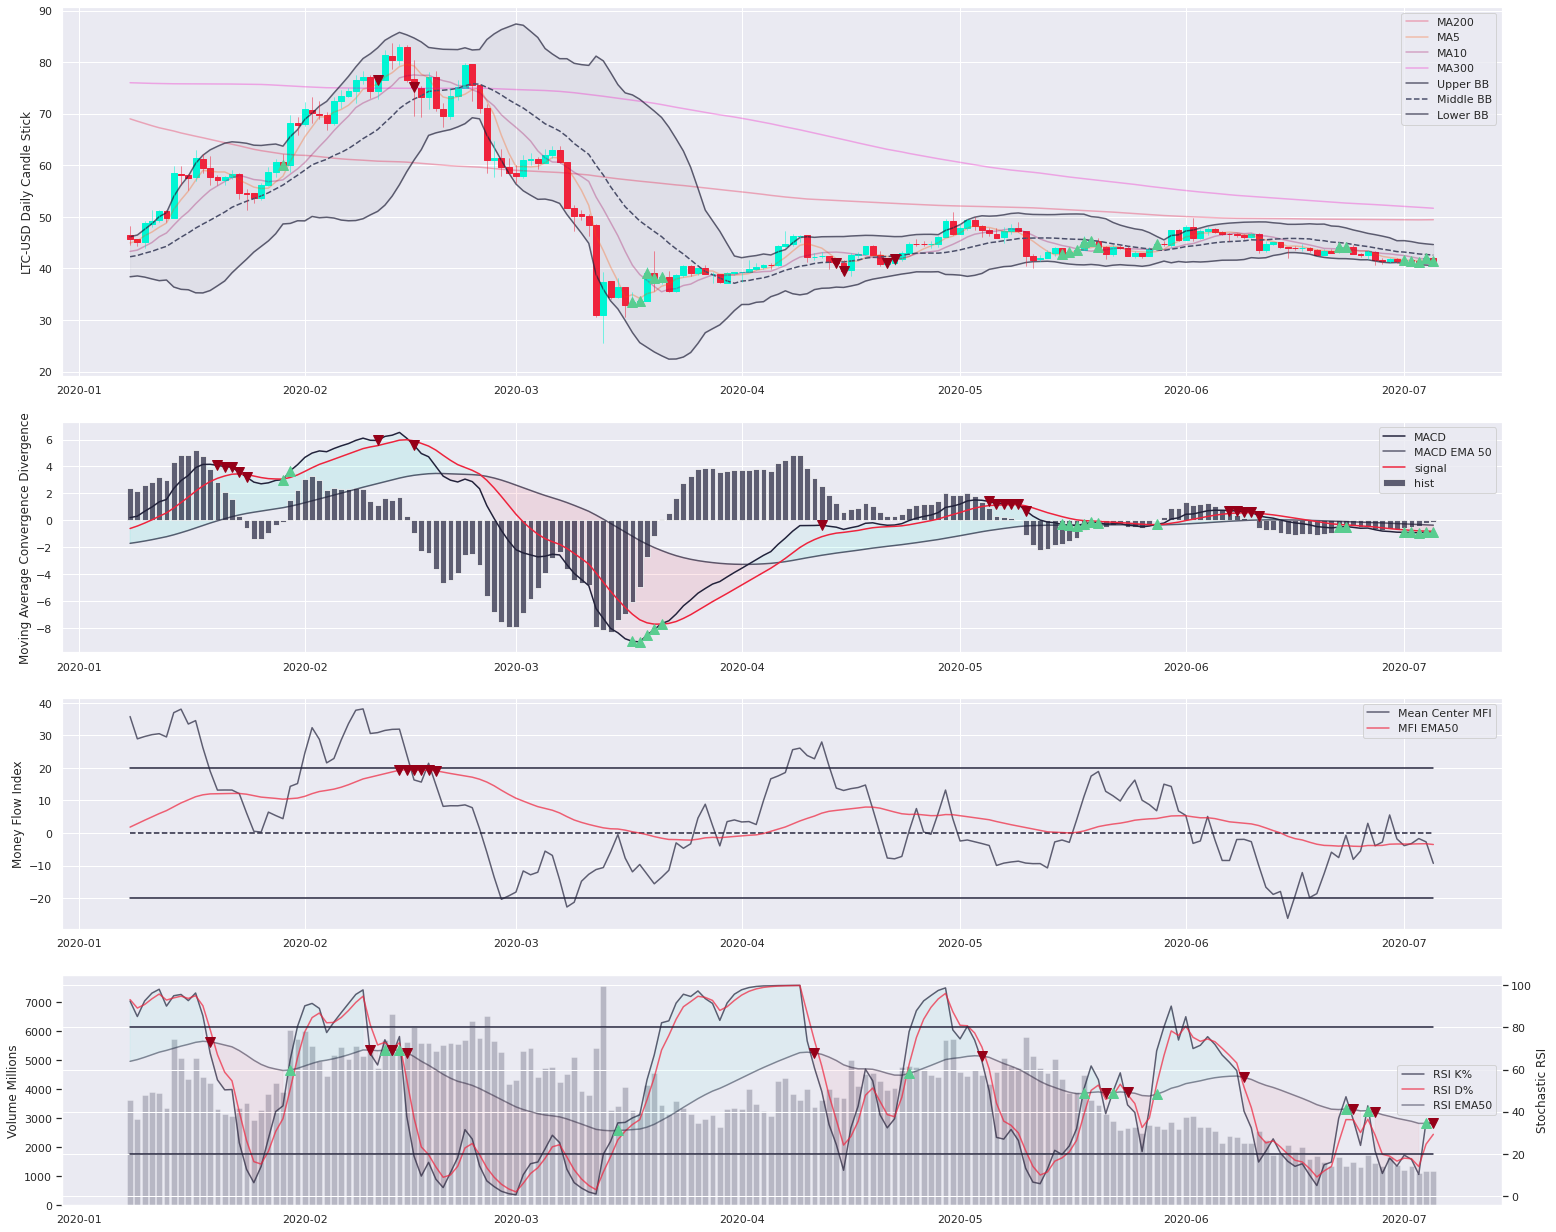

[*********************100%***********************]  1 of 1 completed
********************* BCH-USD *********************


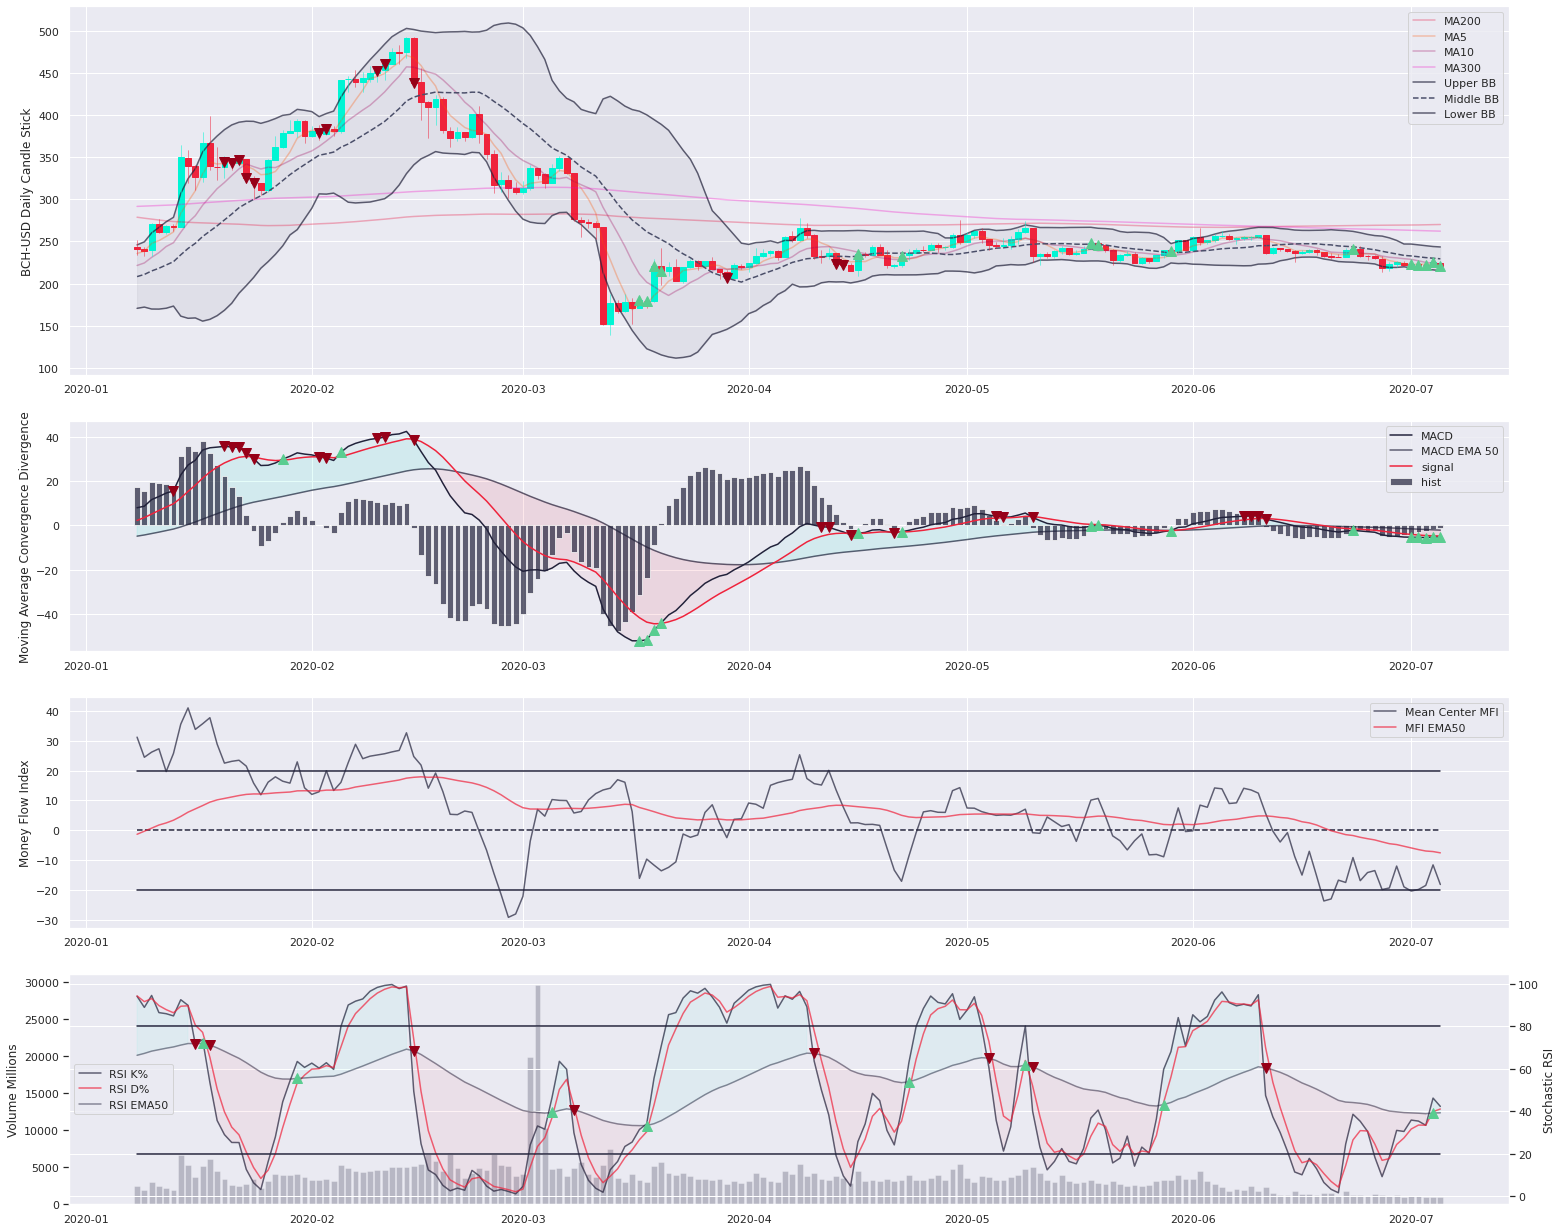

[*********************100%***********************]  1 of 1 completed
********************* XRP-USD *********************


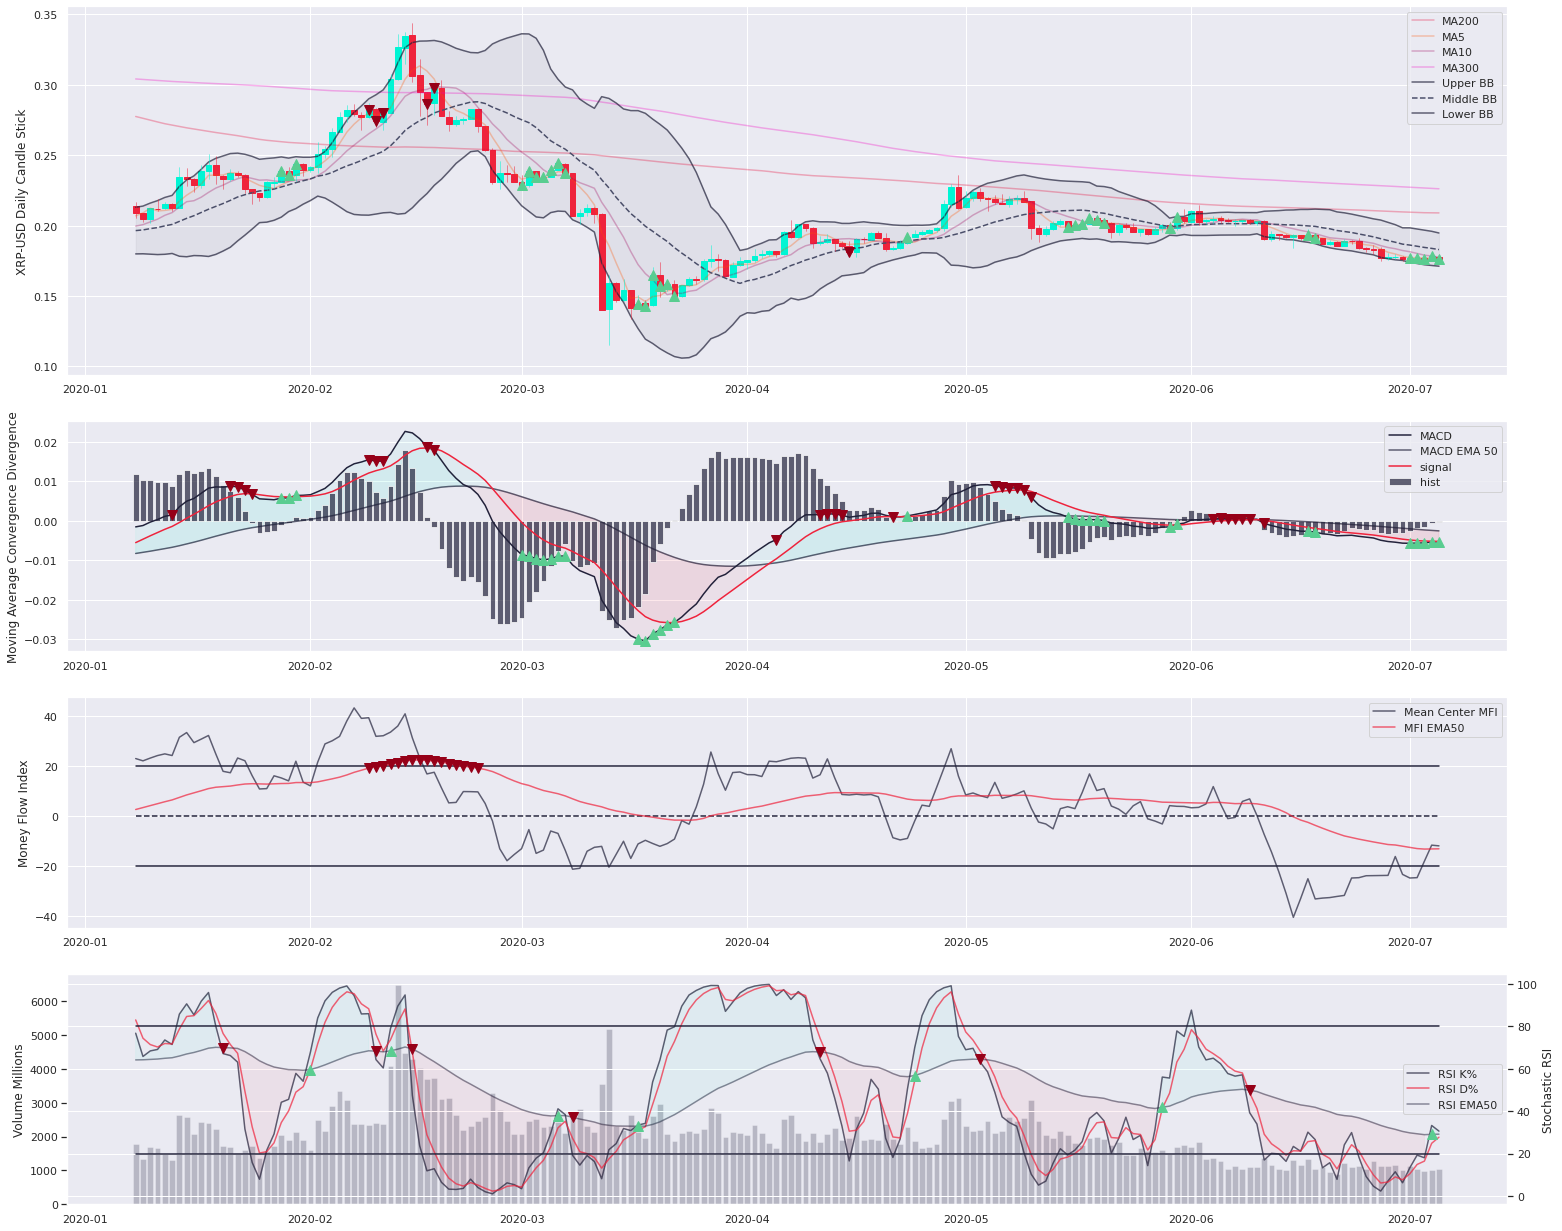

[*********************100%***********************]  1 of 1 completed
********************* EOS-USD *********************


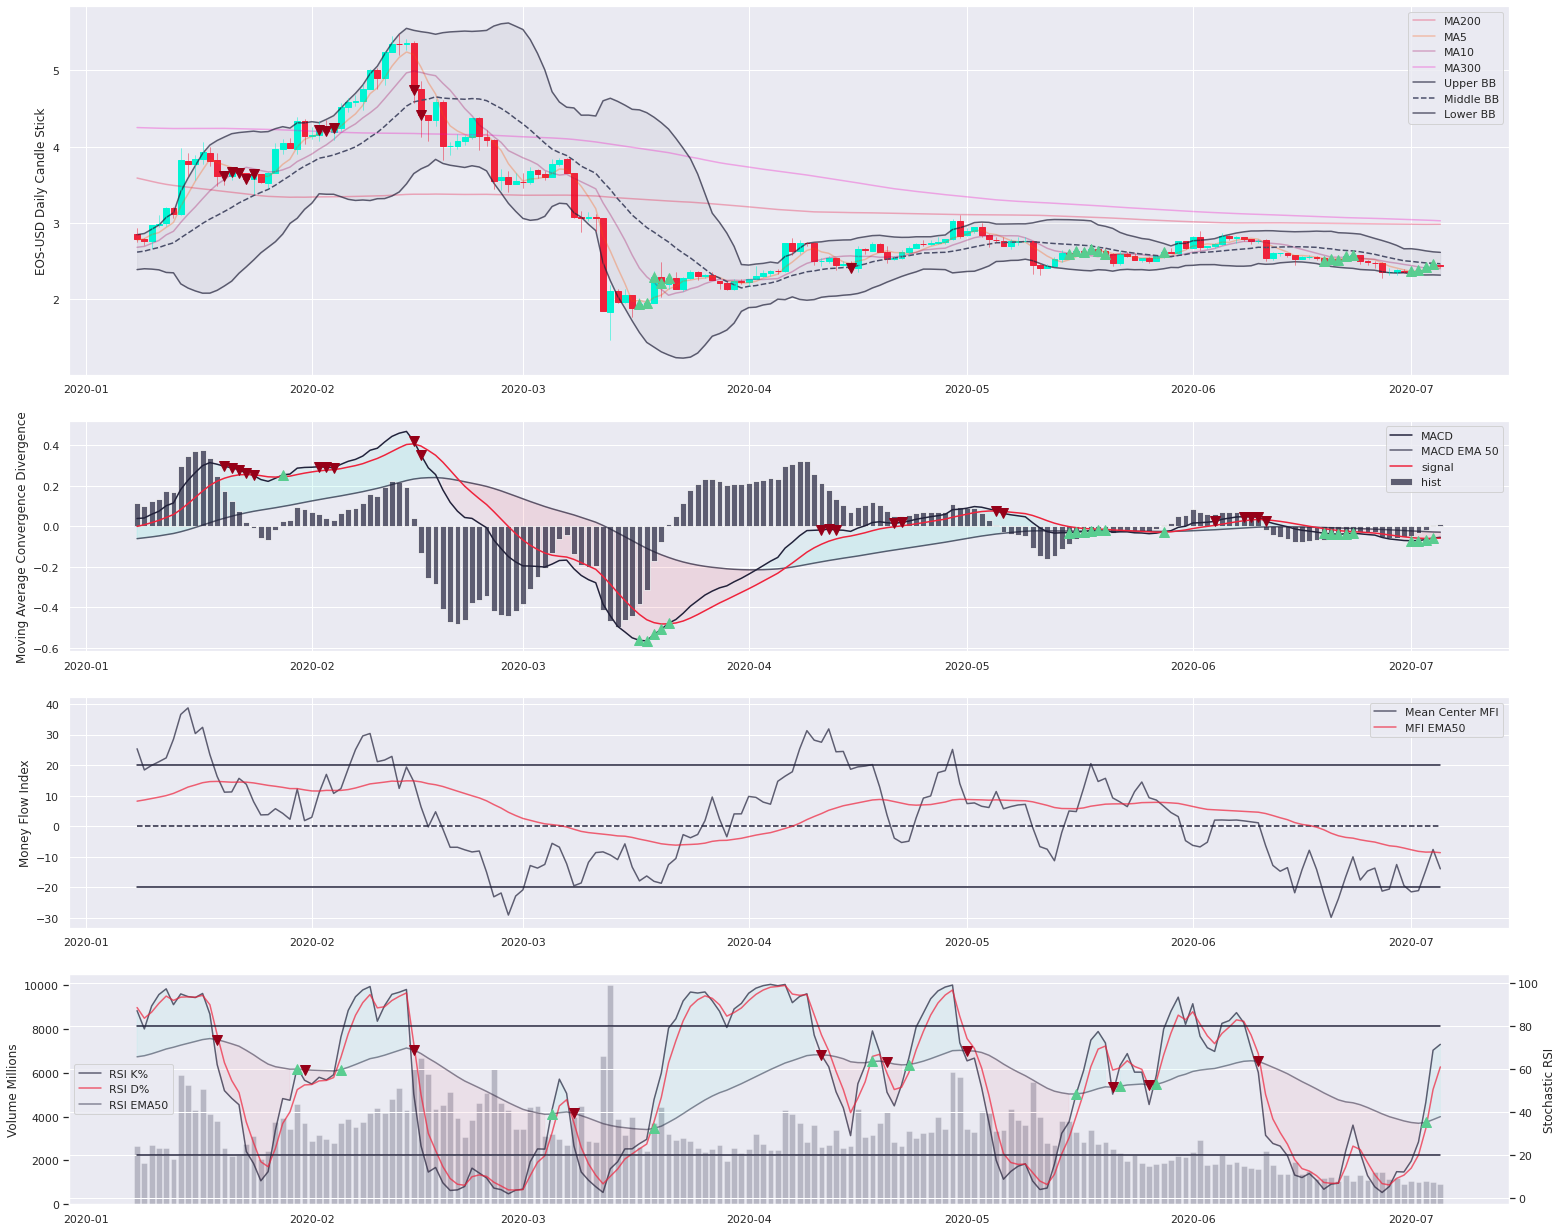

In [220]:

# ticks = ['BTC-AUD','LTC-BTC', 'ETH-BTC', 'BCH-BTC', 'XRP-BTC']
# ticks = ['ETH-BTC','LINK-BTC','BNB-BTC','XRP-BTC',
#          'ADA-BTC','BCH-BTC','EOS-BTC','VET-BTC','BAT-BTC',
#          'LTC-BTC','ZEC-BTC','TRX-BTC','XMR-BTC','XLM-BTC',
#          'NEO-BTC','ETC-BTC','ZRX-BTC','BNT-BTC','KNC-BTC',
#          'QTUM-BTC','RLC-BTC','DASH-BTC','LRC-BTC','XVG-BTC',
#          'DGB-BTC','SC-BTC','FUN-BTC','MIOTA-BTC','ICX-BTC',
#          'NANO-BTC','MCO-BTC','KMD-BTC','ARDR-BTC','REP-BTC',
#          'STRAT-BTC','ARK-BTC','BTS-BTC','WAVES-BTC',
#          'MTL-BTC','WTC-BTC','CVC-BTC','XEM-BTC','XZC-BTC']

ticks = ['BTC-USD', 'ETH-USD', 'LTC-USD', 'BCH-USD', 'XRP-USD', 'EOS-USD']
# ticks = ['BTC-AUD']
# ticks = ['ETH-BTC','LINK-BTC','BNB-BTC','XRP-BTC']
# ticks = ['APT.AX','Z1P.AX','AMD', 'INTC', 'NFLX', 'TSLA']

# BIG BOYS
# ticks = ['AAPL', 'FB', 'MSFT', 'AMZN', 'AMD', 'INTC', 'NFLX', 'TSLA']
# ticks = ['SPY']
# ticks = [ '^GSPC', '^DJI', '^IXIC', '^AXJO']

# COMMSEC ETF TICKS
# ticks = ['IOZ.AX', 'NDQ.AX', 'IOO.AX', 'IEM.AX', 'SYI.AX', 'IXJ.AX','ETHI.AX' ]

# MAKING DATAFRAME
yf.pdr_override() 
for tick in ticks: 
  data = pdr.get_data_yahoo(tick, interval = '1d', period = "3y")
  print('*********************',tick,'*********************')      
  data = get_indicators(data)
  data['macd_buy_signal'] = data.apply(macd_buy_signal, axis=1)
  data['macd_sell_signal'] = data.apply(macd_sell_signal, axis=1)
  # data['CCI_buy_signal'] = data.apply(cci_buy_signal, axis=1)
  # data['CCI_sell_signal'] = data.apply(cci_sell_signal, axis=1)
  data['MFI_buy_signal'] = data.apply(MFI_buy_signal, axis=1)
  data['MFI_sell_signal'] = data.apply(MFI_sell_signal, axis=1)
  # data['VWAP_buy_signal'] = data.apply(vwap_buy_signal, axis=1)
  # data['VWAP_sell_signal'] = data.apply(vwap_sell_signal, axis=1)
  data['RSI_buy_signal'] = data.apply(rsi_buy_signal, axis=1)
  data['RSI_sell_signal'] = data.apply(rsi_sell_signal, axis=1)
  data = patterns(data)
  data['Buy_Signal'] = data.apply(buy_conditions, axis=1)
  data['Sell_Signal'] = data.apply(sell_conditions, axis=1)
  # I recommend the time frame looked at is approx ~250 days or less to best visualise the the markers (60 days for stocks)
  plot_chart(data, len(data)-180,len(data), tick) # data,min_date_len, max_date_len, tick   len(data)-250

# Evnironment to Test Strategy

In [204]:

def trade_env(data, tick, print_ = True):
  CAPITAL = 100 # units
  COMMISSION = 0.01
  units = 0

  def neat_date(x):
    return str(x).replace("00:00:00","")

  for i in range(len(data)):

    if (data.Buy_Signal[i] > 0) and (CAPITAL > 0) and (data.Buy_Signal[i] < data.middleband[i]): # Buy 20 when under the middleband 
      units = units + (20/data.Buy_Signal[i])*(1-COMMISSION) # How much to buy - commisson
      CAPITAL = CAPITAL - 20
      # if (print_ == True):
      #   print(f'{neat_date(data.index[i])} : BUY {20/data.Buy_Signal[i]} at {data.Buy_Signal[i]}')

    if (data.Buy_Signal[i] > 0) and (CAPITAL > 0) and (data.Buy_Signal[i] > data.middleband[i]): # Buy 10 when over the middleband 
      units = units + (10/data.Buy_Signal[i])*(1-COMMISSION) # How much to buy - commisson
      CAPITAL = CAPITAL - 10
      # if (print_ == True):
      #   print(f'{neat_date(data.index[i])} : BUY {10/data.Buy_Signal[i]} at {data.Buy_Signal[i]}')


    if (units > 0):
      if (data.Sell_Signal[i] > 0): # Sell
        sell_units = 10/data.Sell_Signal[i]
        CAPITAL = CAPITAL + ((data.Sell_Signal[i]*(sell_units))*(1-COMMISSION)) # sellign 50 percent everytime - commisson
        # if (print_ == True):
        #   print(f'{neat_date(data.index[i])} : SELL {units} at {data.Sell_Signal[i]}')
        units = units-sell_units

    if (i == (data.shape[0]-1)): # Print portfolio value of last day
      portfolio_val = (units*data.Close[i]) + CAPITAL # Current portfolio value
      print(f'{neat_date(data.index[i])} : APPROX {tick} PORTFOLIO VALUE {portfolio_val}')
    
  return portfolio_val
ticks = ['ETH-BTC','LINK-BTC','BNB-BTC',
         'ADA-BTC','BCH-BTC','EOS-BTC','VET-BTC','BAT-BTC',
         'LTC-BTC','ZEC-BTC','TRX-BTC','XMR-BTC','XLM-BTC',
         'NEO-BTC','ETC-BTC','ZRX-BTC','BNT-BTC','KNC-BTC',
         'QTUM-BTC','RLC-BTC','DASH-BTC','LRC-BTC','XVG-BTC',
         'DGB-BTC','SC-BTC','FUN-BTC','MIOTA-BTC','ICX-BTC',
         'NANO-BTC','MCO-BTC','KMD-BTC','ARDR-BTC','REP-BTC',
         'STRAT-BTC','ARK-BTC','BTS-BTC','WAVES-BTC',
         'MTL-BTC','CVC-BTC','XEM-BTC','XZC-BTC']
# ticks = ['BTC-USD', 'ETH-USD', 'LTC-USD', 'BCH-USD', 'XRP-USD', 'EOS-USD']
# ticks = ['AAPL', 'FB', 'MSFT', 'AMZN', 'AMD', 'INTC', 'NFLX', 'TSLA']
portval = []
for tick in ticks: 
  data = pdr.get_data_yahoo(tick, interval = '1d', period = "2y")
  print('*********************',tick,'*********************')      
  data = get_indicators(data)
  data = patterns(data)
  data['Buy_Signal'] = data.apply(buy_conditions, axis=1)
  data['Sell_Signal'] = data.apply(sell_conditions, axis=1)
  val = trade_env(data,tick)
  portval.append(val)

  """
  """

[*********************100%***********************]  1 of 1 completed
********************* ETH-BTC *********************
2020-07-05  : APPROX ETH-BTC PORTFOLIO VALUE 96.59974476104512
[*********************100%***********************]  1 of 1 completed
********************* LINK-BTC *********************
2020-07-05  : APPROX LINK-BTC PORTFOLIO VALUE 455.1764946584003
[*********************100%***********************]  1 of 1 completed
********************* BNB-BTC *********************
2020-07-05  : APPROX BNB-BTC PORTFOLIO VALUE 72.42401591064068
[*********************100%***********************]  1 of 1 completed
********************* ADA-BTC *********************
2020-07-05  : APPROX ADA-BTC PORTFOLIO VALUE 115.21002223807768
[*********************100%***********************]  1 of 1 completed
********************* BCH-BTC *********************
2020-07-05  : APPROX BCH-BTC PORTFOLIO VALUE 83.94736257207668
[*********************100%***********************]  1 of 1 completed
********

In [58]:
def Average(lst): 
    return sum(lst) / len(lst) 
Average(portval)

105.71111762830898

Code to make a make a gif

In [240]:

# # ticks = ['BTC-AUD','LTC-BTC', 'ETH-BTC', 'BCH-BTC', 'XRP-BTC']
# # ticks = ['ETH-BTC','LINK-BTC','BNB-BTC','XRP-BTC',
# #          'ADA-BTC','BCH-BTC','EOS-BTC','VET-BTC','BAT-BTC',
# #          'LTC-BTC','ZEC-BTC','TRX-BTC','XMR-BTC','XLM-BTC',
# #          'NEO-BTC','ETC-BTC','ZRX-BTC','BNT-BTC','KNC-BTC',
# #          'QTUM-BTC','RLC-BTC','DASH-BTC','LRC-BTC','XVG-BTC',
# #          'DGB-BTC','SC-BTC','FUN-BTC','MIOTA-BTC','ICX-BTC',
# #          'NANO-BTC','MCO-BTC','KMD-BTC','ARDR-BTC','REP-BTC',
# #          'STRAT-BTC','ARK-BTC','BTS-BTC','WAVES-BTC',
# #          'MTL-BTC','WTC-BTC','CVC-BTC','XEM-BTC','XZC-BTC']

# ticks = ['ETH-USD']
# # ticks = ['BTC-USD']
# # ticks = ['APT.AX','Z1P.AX','AMD', 'INTC', 'NFLX', 'TSLA']

# # ticks = ['AAPL', 'FB', 'MSFT', 'AMZN', 'AMD', 'INTC', 'NFLX', 'TSLA']
# ticks = ['INTC']

# # ticks = [ '^GSPC', '^DJI', '^IXIC', '^AXJO']

# # MAKING DATAFRAME
# yf.pdr_override() 
# for tick in ticks: 
#   data = pdr.get_data_yahoo(tick, interval = '1d', period = "4y")
#   print('*********************',tick,'*********************')      
#   data = get_indicators(data)
#   data['macd_buy_signal'] = data.apply(macd_buy_signal, axis=1)
#   data['macd_sell_signal'] = data.apply(macd_sell_signal, axis=1)
#   # data['CCI_buy_signal'] = data.apply(cci_buy_signal, axis=1)
#   # data['CCI_sell_signal'] = data.apply(cci_sell_signal, axis=1)
#   data['MFI_buy_signal'] = data.apply(MFI_buy_signal, axis=1)
#   data['MFI_sell_signal'] = data.apply(MFI_sell_signal, axis=1)
#   data['RSI_buy_signal'] = data.apply(rsi_buy_signal, axis=1)
#   data['RSI_sell_signal'] = data.apply(rsi_sell_signal, axis=1)
#   # data = patterns(data)
#   data['Buy_Signal'] = data.apply(buy_conditions, axis=1)
#   data['Sell_Signal'] = data.apply(sell_conditions, axis=1)
#   # I recommend the time frame looked at is approx ~250 days or less to best visualise the the markers (60 days for stocks)
#   for i in np.arange(560,700,14): #1080
#     plot_chart(data, 300 + i,480+i,i, tick) # data,min_date_len, max_date_len, tick   len(data)-250